# Ocular Disease Intelligent Recognition (ODIR)
## Using Convolutional Neural Network to Predict Ocular Diseases

Project by: 
    22BAI1213 Joshua S Raju, 22BRS1372 Md Rameez Haider, 22BAI1427 Shubham Yadav, 22BAI1425 Anton K Sam

This particular CNN model aims to predict three types of Ocular Diseases:
1. Cataract

Dataset : https://www.kaggle.com/datasets/andrewmvd/ocular-disease-recognition-odir5k

## Importing Dependencies

In [1]:
import numpy as np
import os

import cv2
import matplotlib.pylab as plt
import imghdr

import tensorflow as tf

Tensorflow GPU Management 

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## Cleaning Image Data

In [3]:
data_dir = 'imgdata_v2'

In [4]:
img_exts = ['jpeg', 'jpg', 'png']
img_exts

['jpeg', 'jpg', 'png']

In [5]:
# from PIL import ImageFile
# ImageFile.LOAD_TRUNCATED_IMAGES = True

for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        img_path = os.path.join(data_dir, image_class,image)
        img = plt.imread(img_path)
        ext = imghdr.what(img_path)
        try:
            if ext not in img_exts:
                os.remove(img_path)
                print('{} successfully removed'.format(img_path))
        except Error as e :
                print('Issue with {}'.format(img_path))

## Image Enhancement Functions

 <i>Crop Function</i>

In [6]:
lower = np.array([0,0,0])
higher = np.array([30,30,30])

def crop(image):
    img_copy = image.copy()
    mask  = cv2.inRange(image, lower, higher)
    inverted_mask = cv2.bitwise_not(mask)

    cont,_ = cv2.findContours(inverted_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cv2.drawContours(image, cont, -1, 255, 10)

    c = max(cont, key=cv2.contourArea)
    x,y,w,h = cv2.boundingRect(c)
    img_cropped = img_copy[y:y+h, x:x+w]

    print('{} successfully cropped'.format(img_path))
    
    return img_cropped

<i>Contour Detection Function</i>

In [7]:
lower = np.array([0,0,0])
higher = np.array([30,30,30])

def contour(image):
    mask  = cv2.inRange(image, lower, higher)
    inverted_mask = cv2.bitwise_not(mask)
    cont,_ = cv2.findContours(inverted_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    return len(cont)

<i> Sharpening Function </i>

In [8]:
kernel_sharpen = np.array([[-1,-1,-1],
                          [-1,9,-1],
                          [-1,-1,-1]])

def sharpen(image):
    img_sharpen = cv2.filter2D(image, -1, kernel_sharpen)

    return img_sharpen

<i> Save Function </i>

In [9]:
def save(path, image):
    plt.imsave(path, image)

### PreProcessing Image

In [10]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        img_path = os.path.join(data_dir, image_class,image)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if img[0][0][0] == 255:
            os.remove(img_path)
            print('{} White-background image successfully removed'.format(img_path))
        elif img.shape[0] != img.shape[1]:
            img_crop = crop(img)
            img_resize = cv2.resize(img_crop, (512,512))
            img_sharpen = sharpen(img_resize)
            save(img_path, img_sharpen)
        # elif contour(img)>1:
        #     os.remove(img_path)
        #     print('{} Non-transformable image removed'.format(img_path))
        else:
            img_resize = cv2.resize(img, (512,512))
            img_sharpen = sharpen(img_resize)
            save(img_path, img_sharpen)  

imgdata_v2\cataract\2174_right.jpg White-background image successfully removed
imgdata_v2\cataract\2175_left.jpg White-background image successfully removed
imgdata_v2\cataract\2176_left.jpg White-background image successfully removed
imgdata_v2\cataract\2177_right.jpg White-background image successfully removed
imgdata_v2\cataract\2178_right.jpg White-background image successfully removed
imgdata_v2\cataract\2179_right.jpg White-background image successfully removed
imgdata_v2\cataract\2180_left.jpg White-background image successfully removed
imgdata_v2\cataract\2180_right.jpg White-background image successfully removed
imgdata_v2\cataract\2181_left.jpg White-background image successfully removed
imgdata_v2\cataract\2181_right.jpg White-background image successfully removed
imgdata_v2\cataract\2182_left.jpg White-background image successfully removed
imgdata_v2\cataract\2182_right.jpg White-background image successfully removed
imgdata_v2\cataract\cataract_001.png successfully cropped

## Creating Image Dataset

In [11]:
dataset = tf.keras.utils.image_dataset_from_directory(data_dir, image_size=(256, 256))

Found 2081 files belonging to 2 classes.


In [12]:
batch = dataset.as_numpy_iterator().next()
len(batch)

2

In [13]:
classes = ['cataract', 'normal']
classes

['cataract', 'normal']

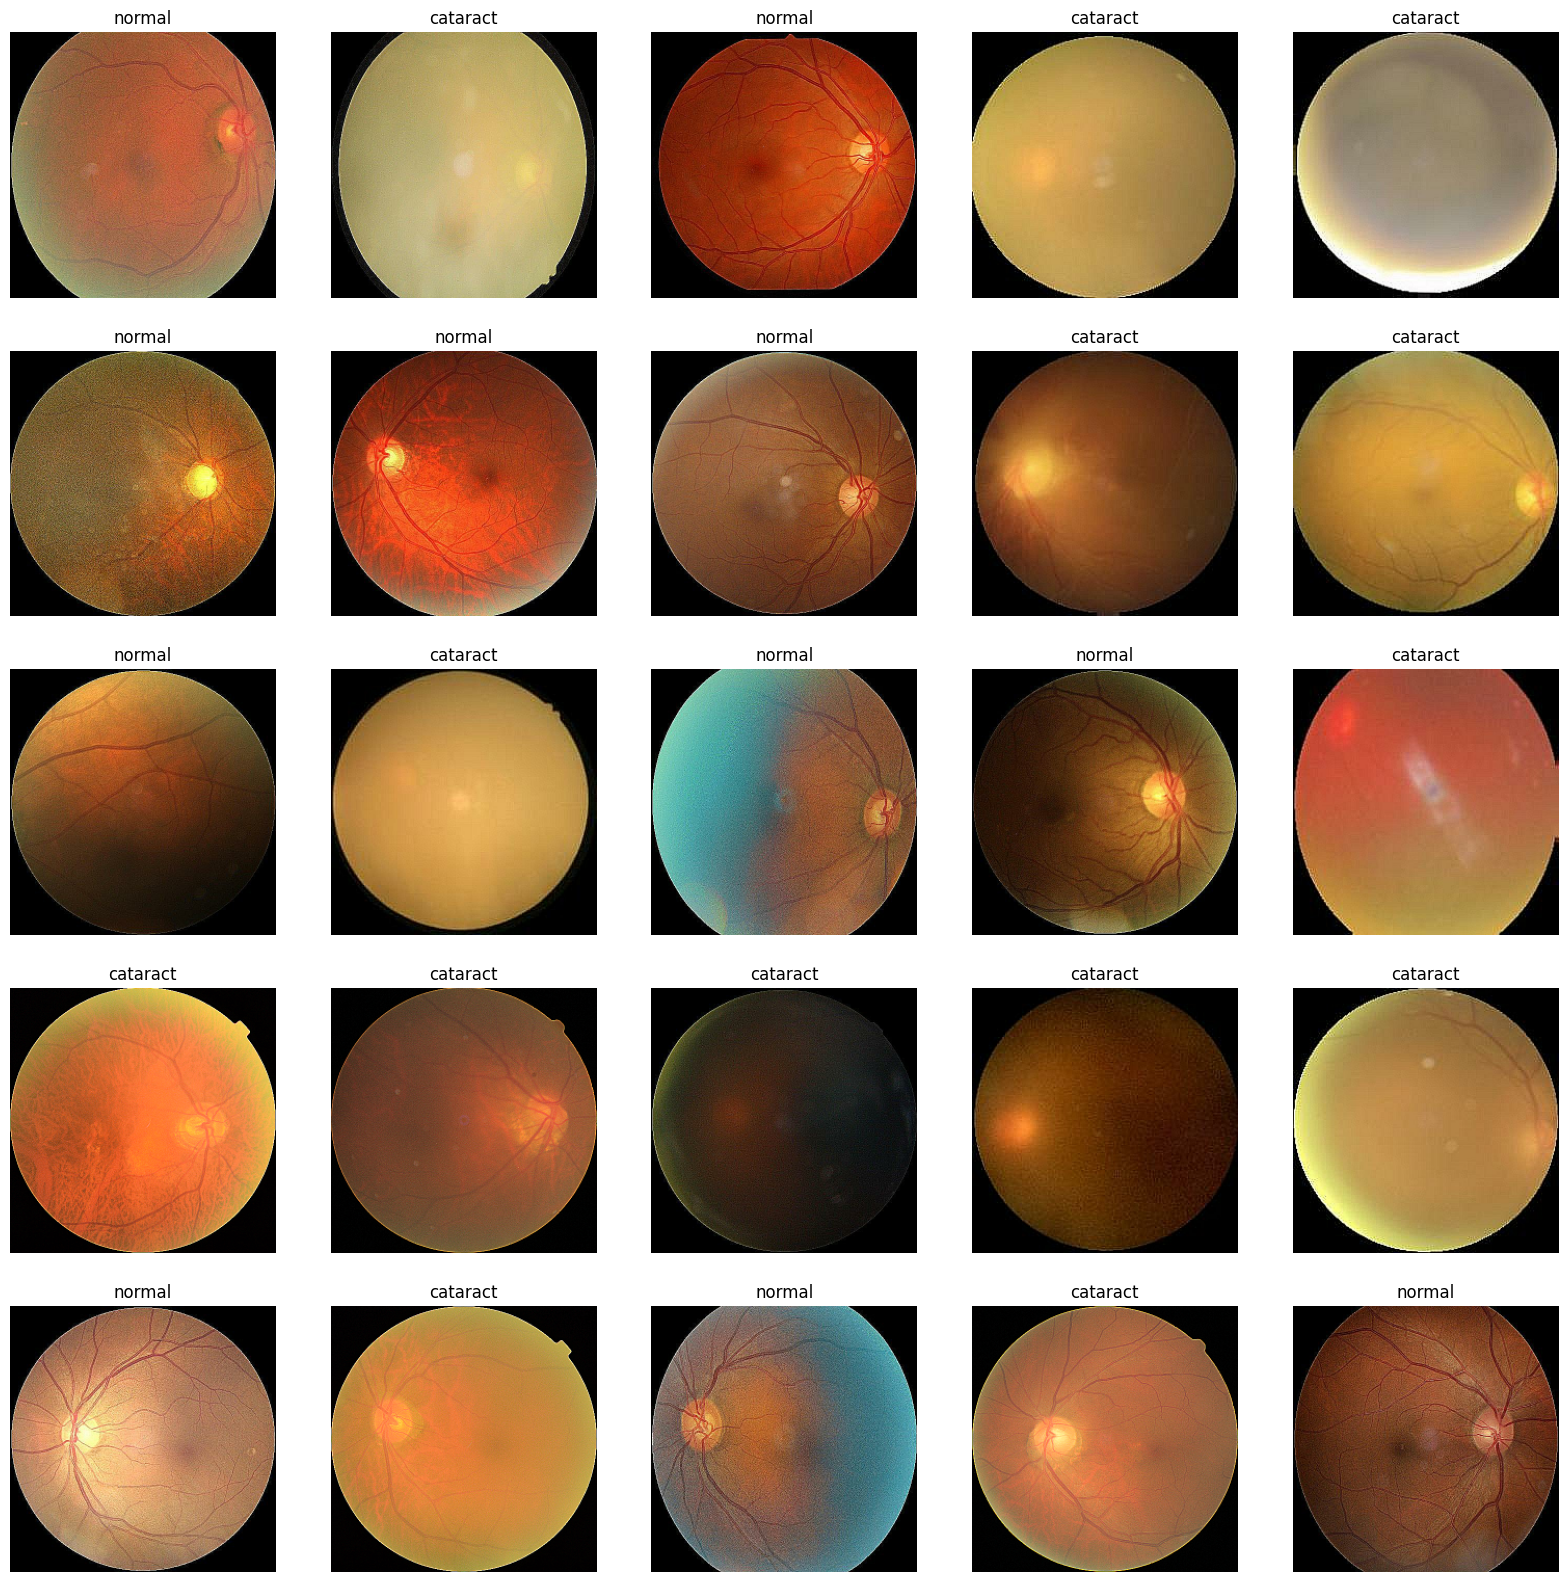

In [14]:
fig, axs = plt.subplots(5,5, figsize=(20,20))
for idx, img in enumerate(batch[0][:25]):
    row = idx//5
    col = idx%5

    axs[row, col].imshow(img.astype(int))
    axs[row, col].axis('off')
    axs[row, col].set_title(classes[batch[1][idx]])

## Image Normalization

In [18]:
batch[0][0].shape, batch[0][0].max(), batch[0][0].min()

((256, 256, 3), 255.0, 0.0)

In [22]:
data = dataset.map(lambda x, y: (x/255, y))

In [23]:
data.as_numpy_iterator().next()[0]

array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]],


       [[[0., 0., 0.],
         [0., 0., 0.],
         [0., 

In [24]:
data.as_numpy_iterator().next()[0].max(), data.as_numpy_iterator().next()[0].min()

(1.0, 0.0)

In [25]:
len(data)

66

## Splitting Dataset 

In [26]:
training_size = int(len(data)*0.7)
val_size = int(len(data)*0.2) + 1
test_size = int(len(data)*0.1)

training_size + val_size + test_size

66

In [27]:
training_data = data.take(training_size)
val_data = data.skip(training_size).take(val_size)
test_data =  data.skip(training_size + val_size).take(test_size)

## Creating CNN Model

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [29]:
model = Sequential()

In [30]:
data.as_numpy_iterator().next()[0][0].shape

(256, 256, 3)

In [31]:
model.add(Conv2D(32, (3,3), 1, activation = 'relu', input_shape = (256, 256, 3)))
model.add(MaxPooling2D())
model.add(Dropout(0.5))

model.add(Conv2D(32, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.5))

model.add(Conv2D(16, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.5))

model.add(Conv2D(16, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.5))


model.add(Flatten())

model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))

In [32]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 62, 62, 32)        0

## Training The Model

In [34]:
log_dir = 'LogDir'

In [35]:
tensorflowboard_callback = tf.keras.callbacks.TensorBoard(log_dir)

In [36]:
hist = model.fit(training_data, epochs = 30, validation_data = val_data, callbacks=[tensorflowboard_callback] )

Epoch 1/30
46/46 [==============================] - 22s 160ms/step - loss: 0.6922 - accuracy: 0.5836 - val_loss: 0.6691 - val_accuracy: 0.6875
Epoch 2/30
46/46 [==============================] - 4s 75ms/step - loss: 0.5489 - accuracy: 0.7351 - val_loss: 0.6334 - val_accuracy: 0.6875
Epoch 3/30
46/46 [==============================] - 3s 72ms/step - loss: 0.4670 - accuracy: 0.8193 - val_loss: 0.6079 - val_accuracy: 0.6808
Epoch 4/30
46/46 [==============================] - 3s 72ms/step - loss: 0.3716 - accuracy: 0.8485 - val_loss: 0.5958 - val_accuracy: 0.6763
Epoch 5/30
46/46 [==============================] - 3s 72ms/step - loss: 0.3724 - accuracy: 0.8458 - val_loss: 0.5323 - val_accuracy: 0.7924
Epoch 6/30
46/46 [==============================] - 3s 71ms/step - loss: 0.3442 - accuracy: 0.8526 - val_loss: 0.6219 - val_accuracy: 0.6205
Epoch 7/30
46/46 [==============================] - 3s 72ms/step - loss: 0.3577 - accuracy: 0.8499 - val_loss: 0.5109 - val_accuracy: 0.8036
Epoch 8/30


In [37]:
hist.history

{'loss': [0.6921729445457458,
  0.5488530993461609,
  0.46699216961860657,
  0.3716110587120056,
  0.3724481761455536,
  0.34417495131492615,
  0.35769227147102356,
  0.3214152753353119,
  0.29930663108825684,
  0.30912306904792786,
  0.2915944755077362,
  0.3143465518951416,
  0.29258355498313904,
  0.29837557673454285,
  0.26796436309814453,
  0.25568461418151855,
  0.24402566254138947,
  0.26636794209480286,
  0.24967527389526367,
  0.2500332295894623,
  0.2353822886943817,
  0.27423399686813354,
  0.21541178226470947,
  0.26338180899620056,
  0.2262057065963745,
  0.23785282671451569,
  0.20169278979301453,
  0.20967566967010498,
  0.21977007389068604,
  0.21062934398651123],
 'accuracy': [0.5835598111152649,
  0.7350543737411499,
  0.8192934989929199,
  0.848505437374115,
  0.8457880616188049,
  0.8525815010070801,
  0.84986412525177,
  0.860733687877655,
  0.8729619383811951,
  0.8722826242446899,
  0.8695651888847351,
  0.870244562625885,
  0.8709239363670349,
  0.87160325050354

## Model Performance 

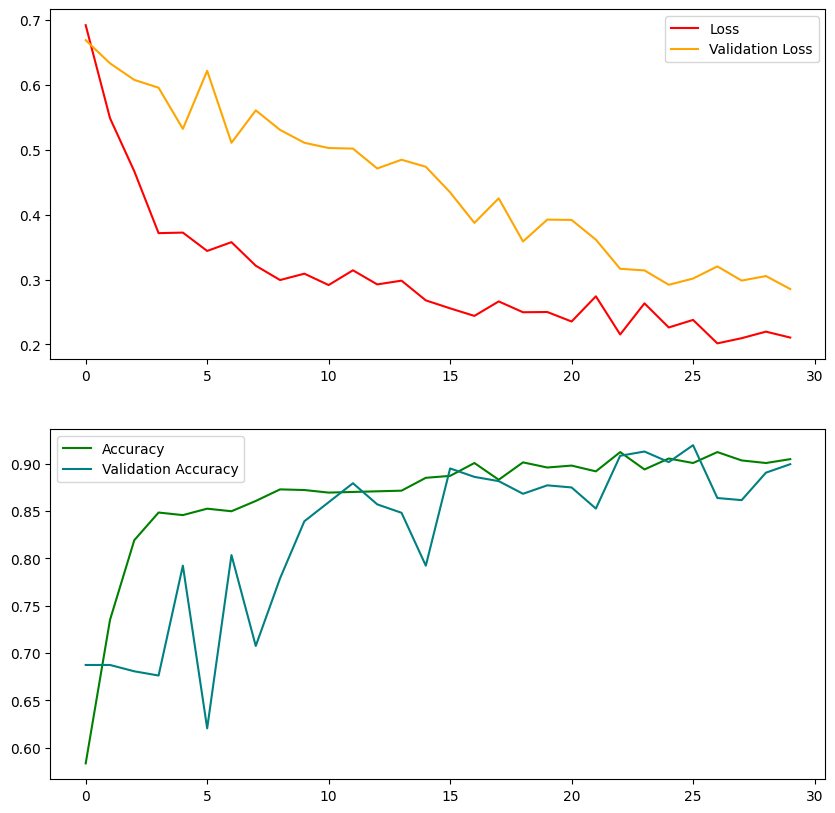

In [39]:
fig, axs = plt.subplots(2, 1, figsize=(10,10))
axs[0].plot(hist.history['loss'], color='red', label='Loss')
axs[0].plot(hist.history['val_loss'], color='orange', label='Validation Loss')
axs[0].legend(loc='upper right')

axs[1].plot(hist.history['accuracy'], 
             color='green', 
             label='Accuracy')
axs[1].plot(hist.history['val_accuracy'], 
             color='teal', 
             label='Validation Accuracy')
axs[1].legend(loc='upper left')

## Evaluating Model

In [42]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, SpecificityAtSensitivity

pre = Precision()
acc = BinaryAccuracy()
rec = Recall()
spe = SpecificityAtSensitivity(0.5)

In [43]:
for batch in test_data.as_numpy_iterator():
    X, y = batch
    y_pred = model.predict(X)
    pre.update_state(y, y_pred)
    rec.update_state(y, y_pred)
    acc.update_state(y, y_pred)
    spe.update_state(y, y_pred)

1/1 [==============================] - 0s 228ms/step


In [44]:
precision = pre.result().numpy()
recall = rec.result().numpy()
f1 = 2 * (precision*recall) / (precision+recall)

print('Accuracy\t:', acc.result().numpy())
print('Precision\t:', precision)
print('Recall\t\t:', recall)
print('Specificity\t:', spe.result().numpy())
print('F1\t\t:', f1)

Accuracy	: 0.91925466
Precision	: 0.8961039
Recall		: 0.9324324
Specificity	: 1.0
F1		: 0.9139073050603324


## Exporting Model

In [45]:
model.save(os.path.join('models', 'ODIR_NoDataAug.h5'))

In [46]:
from tensorflow.keras.models import load_model

model = load_model(os.path.join('models', 'ODIR_NoDataAug.h5'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 62, 62, 32)        0